In [4]:
import numpy as np
images = np.load("images.npy")
pv_out = np.load("pv_outputs.npy")

In [5]:
num_dat = images.shape[0]
indices = np.arange(num_dat)
np.random.shuffle(indices)
X_train, X_val, X_test = images[indices[:int(0.6*num_dat)]], images[indices[int(0.6*num_dat):int(0.8*num_dat)]], images[indices[int(0.8*num_dat):]]
y_train, y_val, y_test = pv_out[indices[:int(0.6*num_dat)]], pv_out[indices[int(0.6*num_dat):int(0.8*num_dat)]], pv_out[indices[int(0.8*num_dat):]]

In [6]:
import tensorflow as tf
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# copied and modified from assignment 2

def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    rel_error = tf.divide(tf.abs(tf.subtract(y, predict)), y)
    accuracy = tf.reduce_mean(rel_error)
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [loss_val, rel_error, accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        errors = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(Xd.shape[0]/batch_size)+1):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, rel_err, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            errors += np.sum(rel_err)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and relative error of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(rel_err)/actual_batch_size))
            iter_cnt += 1
        total_error = errors/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]

        print("Epoch {2}, Overall loss = {0:.3g} and relative error of {1:.3g}"\
              .format(total_loss,total_error,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_error

In [8]:
# Feel free to play with this cell

def my_model(X,y,is_training):
    conv1 = tf.layers.conv2d(
      inputs=X,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
    bn1 = tf.layers.batch_normalization(inputs=conv1, axis=1)
    pool1 = tf.layers.max_pooling2d(inputs=bn1, pool_size=[2, 2], strides=2)
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)
    bn2 = tf.layers.batch_normalization(inputs=conv2, axis=1)
    pool2 = tf.layers.max_pooling2d(inputs=bn2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 20*15*64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=is_training)
    regression = tf.layers.dense(inputs=dropout, units=1)
    regression = tf.reshape(regression, [-1])
    return regression
    
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 60, 80, 3])
y = tf.placeholder(tf.float32, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
mean_loss = tf.losses.mean_squared_error(y, y_out)
# mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(1e-3)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

pass

Training


Iteration 0: with minibatch training loss = 1.23e+07 and relative error of 1


Epoch 1, Overall loss = 4.23e+06 and relative error of 5.66


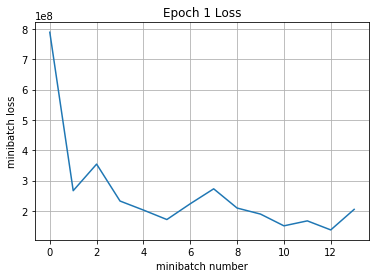

Validation


Epoch 1, Overall loss = 2.21e+06 and relative error of 5.17
Training


Iteration 0: with minibatch training loss = 1.78e+06 and relative error of 4.5


Epoch 1, Overall loss = 1.05e+06 and relative error of 3.01


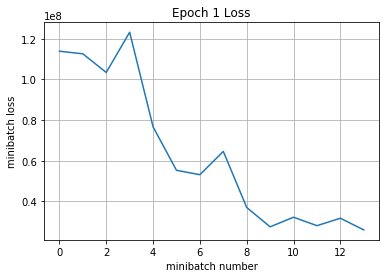

Validation


Epoch 1, Overall loss = 5.67e+05 and relative error of 0.788
Training


Iteration 0: with minibatch training loss = 5.61e+05 and relative error of 0.59


Epoch 1, Overall loss = 3.37e+05 and relative error of 0.927


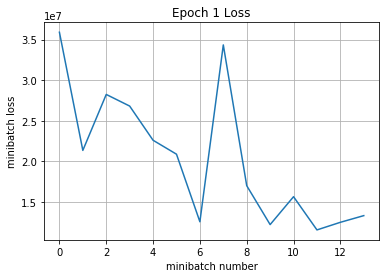

Validation


Epoch 1, Overall loss = 2.64e+05 and relative error of 1.27


In [10]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())

train_loss_hist = []
train_error_hist = []
val_error_hist = []

for i in range(3):
    print('Training')
    train_loss,train_error = run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
    print('Validation')
    val_loss,val_error = run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
    
    train_loss_hist.append(train_loss)
    train_error_hist.append(train_error)
    val_error_hist.append(val_error)

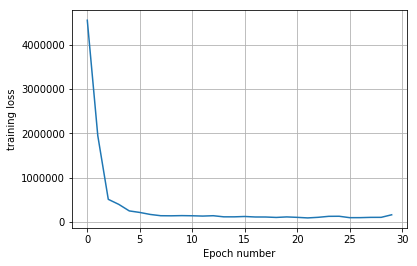

In [17]:
plt.plot(train_loss_hist)
plt.grid(True)
plt.xlabel('Epoch number')
plt.ylabel('training loss')
plt.savefig('training_loss_history.png', bbox_inches='tight')
plt.show()

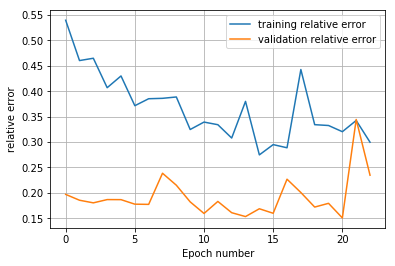

In [20]:
plt.plot(train_error_hist[7:],label = 'training relative error')
plt.plot(val_error_hist[7:],label = 'validation relative error')
plt.grid(True)
plt.xlabel('Epoch number')
plt.ylabel('relative error')
plt.legend()
plt.savefig('relative_error.png', bbox_inches='tight')
plt.show()